In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
#Get data from local
from google.colab import files
uploaded = files.upload()

Saving ab_test_click_data (1).csv to ab_test_click_data (1).csv


In [ ]:
#Loading Click Through Rate Data for AB Test
df = pd.read_csv('ab_test_click_data (1).csv')

In [ ]:
#Display the first few rows
print(df.head())
print(df.describe())
print(df.groupby('group').sum('click'))

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   1989
exp     50005000   6116


A simple bar chart showing the total clicks versus no-clicks in each group can provide a clear visual comparison of user engagement.

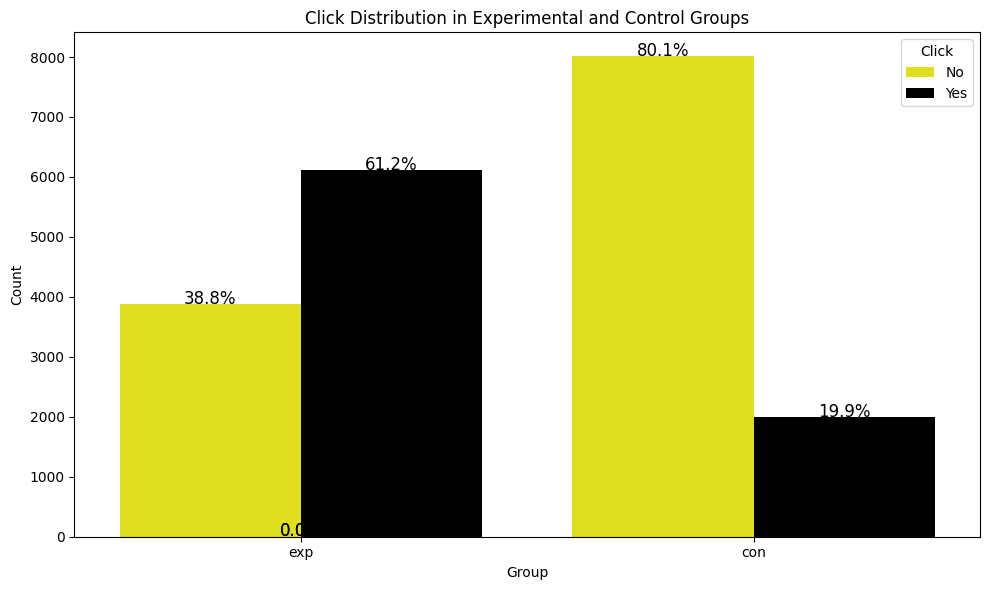

In [ ]:
#Custom palette for yellow and black
palette = {0: 'yellow', 1:'black'}

#Plotting the click distribution for each group can provide a clear visual comparison of user engagement
plt.figure(figsize=(10,6))
ax =sns.countplot(x='group', hue='click', data=df, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])


#Calculate the percentages and annotate the bars
group_counts = df.groupby(['group']).size()
group_click_counts = df.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
  height = p.get_height()
  #Find the group and click type for the current bar
  group = 'exp' if p.get_x() < 0.5 else 'con'
  click = 1 if p.get_x() % 1 > 0.5 else 0
  total = group_counts.loc[group]
  percentage = 100 * height / total
  ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha='center', color='black', fontsize='12')

plt.tight_layout()
plt.show()

β:Probability of Type II Error

(1-β):Power of the test

α:Probability of Type I Error, Significance

δ:Minimum Detectable Effect


In [ ]:
alpha = 0.05 # 5%
print('Alpha: significance level is:', alpha)

delta = 0.1 # 10%
print('Delta: minimum detectable effect is', delta)


Alpha: significance level is: 0.05
Delta: minimum detectable effect is 0.1


Calculating total number of clicks per group by summing clicks

In [ ]:
N_con = df[df['group'] == 'con'].count()
N_exp = df[df['group'] == 'exp'].count()


# calculating the total number of clicks per group by summing 1's
X_con = df.groupby('group')['click'].sum().loc['con']
X_exp = df.groupby('group')['click'].sum().loc['exp']

# printing this for visibility
print(df.groupby('group')['click'].sum())
print('Number of users in Control: ', N_con)
print('Number of users in Experimental: ', N_exp)
print('Number of Clicks in Control: ', X_con)
print('Number of Clicks in Experimental: ', X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of users in Control:  user_id      10000
click        10000
group        10000
timestamp        0
dtype: int64
Number of users in Experimental:  user_id      10000
click        10000
group        10000
timestamp    10000
dtype: int64
Number of Clicks in Control:  1989
Number of Clicks in Experimental:  6116


Calculating Poolde Estimates for Clicks per Group

Click probability in Control Group:  0.1989
Click probability in Experimental Group:  0.6116
Pooled click probability:  user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64


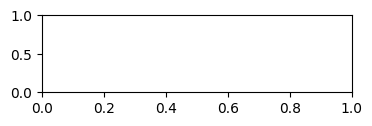

In [ ]:
# computing the estimate of click probability per group
p_con_hat = X_con / N_con
p_con_hat = p_con_hat.iloc[0]
p_exp_hat = X_exp / N_exp
p_exp_hat = p_exp_hat.iloc[0]
print('Click probability in Control Group: ', p_con_hat)
print('Click probability in Experimental Group: ', p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con + X_exp) / (N_con + N_exp)
print('Pooled click probability: ', p_pooled_hat)

Calculating Pooled Variance

In [ ]:
# computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print('p^ pooled is', p_pooled_hat)
print('Pooled variance is: ', pooled_variance)


p^ pooled is user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64
Pooled variance is:  user_id      0.000048
click        0.000048
group        0.000048
timestamp         inf
dtype: float64


Calculating Standard Error and Test statistics

In [ ]:
#computing the standard error of the test
SE = np.sqrt(pooled_variance)
SE = SE.iloc[0]
print("Standard Error is: ", SE)

#computing the test statistics of the Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE

print("Test statistics for Z-sample Z-test is:", Test_stat)

#critical value of the Z-test
Z_crit = stats.norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  0.006942945160376826
Test statistics for Z-sample Z-test is: -59.44163326469381
Z-critical value from Standard Normal distribution:  1.959963984540054


**Calculating p_values of the Z-test**

. A low p-value (p <= 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis

. A high p_value (p>0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.



In [ ]:
#calculating p-value
p_value = 2 * stats.norm.sf(abs(Test_stat))


# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
  """
  We assess whether there is statistical significance based on the p-value and alpha

  Arguments:
  - p_value (float): The p-value resulting from a statistical test.
  - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

  Returns:
  - Prints the assessment of statistical significance.
  """
  #Print the rounded p-value to 3 decimal places
  print(f"p-value of the 2-sample Z-test: {round(p_value, 3)}")

  # Determine statistical significance
  if p_value <= alpha:
    print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured due to random chance. This suggests the new version of the landing page results in a higher CTR")

  else:
    print("There is no statistical significance, indicating that the observed differences between the groups are likely to have occured due to random chance. This suggests the new version of the landing page results in a lower CTR")

is_statistical_significance(p_value, alpha)

p-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occured due to random chance. This suggests the new version of the landing page results in a higher CTR


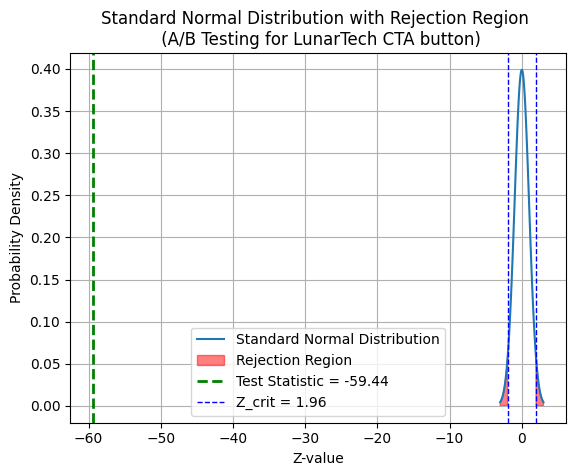

In [ ]:
#Parameters for the standard normal distribution
mu = 0 #Mean
sigma = 1 #Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = stats.norm.pdf(x, mu, sigma)


#Plotting the standard normal distribution
plt.plot(x,y, label='Standard Normal Distribution')
# Shade the rejection region for a two tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')
# Adding Test statistic
plt.axvline(x=Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')
# Adding Z-critical values
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z_crit = {Z_crit:.2f}')
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Standard Normal Distribution with Rejection Region \n (A/B Testing for LunarTech CTA button)')
plt.legend()
plt.grid(True)
plt.show()


Calculating Confidence Interval of the Test

In [ ]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval

CI_95 = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3), # Lower bound of the CI, rounded to 3 decimal places
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3)  # Upper bound of the CI rounded to 3 decimal places
]
# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is:", CI_95)

# Here, the confidence interval provides a range of values within which the true difference between the experimental and control group

Confidence Interval of the 2 sample Z-test is: [np.float64(0.399), np.float64(0.426)]


Testing for Practical Significance in A/B Testing

In [ ]:
def is_Practically_significant(delta, CI_95):
  """
  We assess here if the difference between the experimental and control group is practically significant using the Minimum Detectable Effect (MDE)

  Arguments:
  - delta (float): The Minimum Detectable Effect (MDE) considered for prectical significance
  - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% confidence interval.

  Returns:
  - Prints whether the experiment has practical significance using the MDE and CI
  """

  # Extract lower bound of 95% Confidence Interval
  lower_bound_CI = CI_95[0]

  # Check if the lower bound of the CI is greater than or equal to delta
  if lower_bound_CI >= delta:
    print(f"We have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is practically significanct.")
    return True
  else:
    print("We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant")
    return False

# Call the function
significance = is_Practically_significant(delta, CI_95)
print("Lower bound of 95% confidence interval is: ", CI_95[0])

We have practical significance! 
With MDE of 0.1, The difference between Control and Experimental group is practically significanct.
Lower bound of 95% confidence interval is:  0.399


We conclude that the ENROLL NOW button statistically leads to higher click through rate.

Based on this research we should replace the RESUME FREE TRIAL button with the new ENROLL NOW button.